In [2]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import glob
import sys
import os
import tqdm

In module 'Darwin':
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/OSByteOrder.h:14:1: error: '_OSSwapInt16' has different definitions in different modules; definition in module 'Darwin.libkern.OSByteOrder' first difference is return type is 'uint16_t' (aka 'unsigned short')
uint16_t
^~~~~~~~
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/_OSByteOrder.h:49:1: note: but in 'DarwinFoundation.OSByteOrder' found different return type '__uint16_t' (aka 'unsigned short')
__uint16_t
^~~~~~~~~~
In module 'Darwin':
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/OSByteOrder.h:24:1: error: '_OSSwapInt32' has different definitions in different modules; definition in module 'Darwin.libkern.OSByteOrder' first difference is return type is 'uint32_t' (aka 'unsigned int')
uint32_t
^~~~~~~~


Welcome to JupyROOT 6.30/04


In [3]:
import os
os.getcwd()

'/Users/ajbiffl/Documents/CDMS/defects/doublecap/analysis'

In [4]:
detectors = ['lowmass', 'highmass1', 'highmass2']


iontable = [
    '../build/capture_sim/simdata_20250120_111624_t0.root', # 500k primaries
    '../build/capture_sim/simdata_20250121_133627_t0.root', # 500k
]
# iontable = '../build/capture_sim/simdata_20250114_121957_t0.root' # using first versions of throwing ions directly 
Niontable = 2*500e3

ngun = [
    '../build/test_data/testsim_20250120_111823_t0.root', # 5M primaries
    '../build/test_data/testsim_20250121_112334_t0.root' # 5M primaries
]

In [5]:
# get energy of gammas originating in lowmass (not grouping by event)
def get_gamma_spec(fnames, Ebins, all_caps = False):
    hists = {det: ROOT.TH1D(
        fnames[0] + det,
        fnames[0] + det,
        len(Ebins)-1, Ebins
    ) for det in detectors}

    for fname in fnames:

        tfile = ROOT.TFile.Open(fname, 'READ')
        tree = tfile.Get('tree')

        N = tree.GetEntries()
        numcaps = tree.GetEntries("IsCapture&&VolName==ParentVol&&PName!=\"gamma\"")

        for k in range(N):
            tree.GetEntry(k)

            PName = getattr(tree, 'PName')
            KE = float(getattr(tree, 'KE'))
            VolName = getattr(tree, 'VolName')
            ParentVol = getattr(tree, 'ParentVol')

            if PName == 'gamma'\
                and ParentVol == 'lowmass'\
                and VolName in ('highmass1', 'highmass2'):

                hists[VolName].Fill(KE)
    
        tfile.Close()

    # end of fnames loop

    cts = {det: np.zeros(Ebins.shape) for det in detectors}

    for det in detectors:
        for i in range(1, len(Ebins)):
            cts[det][i-1] = hists[det].GetBinContent(i)

    return cts

# get total energy deposited per event from gammas
def get_gamma_deposit_spec(fnames, Ebins, all_caps = False):
    hists = {det: ROOT.TH1D(
        fnames[0] + det,
        fnames[0] + det,
        len(Ebins)-1, Ebins
    ) for det in detectors}

    numcaps = 0


    for fname in fnames:

        tfile = ROOT.TFile.Open(fname, 'READ')
        tree = tfile.Get('tree')

        N = tree.GetEntries()
        numcaps += tree.GetEntries("IsCapture&&VolName==ParentVol&&PName!=\"gamma\"")

        last_event = -1

        Edep_evt = {det: 0. for det in detectors}
        hascap = False

        for k in range(N):
            tree.GetEntry(k)

            IsCapture = bool(int(getattr(tree, 'IsCapture')))
            EventNum = int(getattr(tree, 'EventNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            
            if IsCapture:
                hascap = True

            if abs(EventNum - last_event) > 1e-6: # if new event
                last_event = EventNum

                for det in detectors:
                    if (hascap or all_caps) and Edep_evt[det] > 0:
                        hists[det].Fill(Edep_evt[det])
        
                # reset variables
                Edep_evt = {det: 0. for det in detectors}
                hascap = False
        
            # all events: add current Edep to Edep_evt
            Edep_evt[VolName] += Edep


        tfile.Close()

    # end of fnames loop

    cts = {det: np.zeros(Ebins.shape) for det in detectors}

    for det in detectors:
        for i in range(1, len(Ebins)):
            cts[det][i-1] = hists[det].GetBinContent(i)

    return cts, numcaps

In [6]:
Emin = 0.5e-6
Emax = 10 # MeV
Nbins = 200

logbins = False
if logbins:
    Ebins = np.geomspace(Emin, Emax, Nbins+1, endpoint = False) 
else:    
    Ebins = np.linspace(Emin, Emax, Nbins+1, endpoint = True) # bin edges (MeV)
dE = (Ebins[1:] - Ebins[:-1]).mean()
Emids = Ebins + dE/2 # bin centers

# measured energy spectrum
iontable_cts, _ = get_gamma_deposit_spec(iontable, Ebins, all_caps = True)
ngun_cts, numcaps = get_gamma_deposit_spec(ngun, Ebins)

In [7]:
# gamma spectrum
iontablegam_cts = get_gamma_spec(iontable, Ebins, all_caps = True)
ngungam_cts = get_gamma_spec(ngun, Ebins)

In [8]:
numcaps

40859

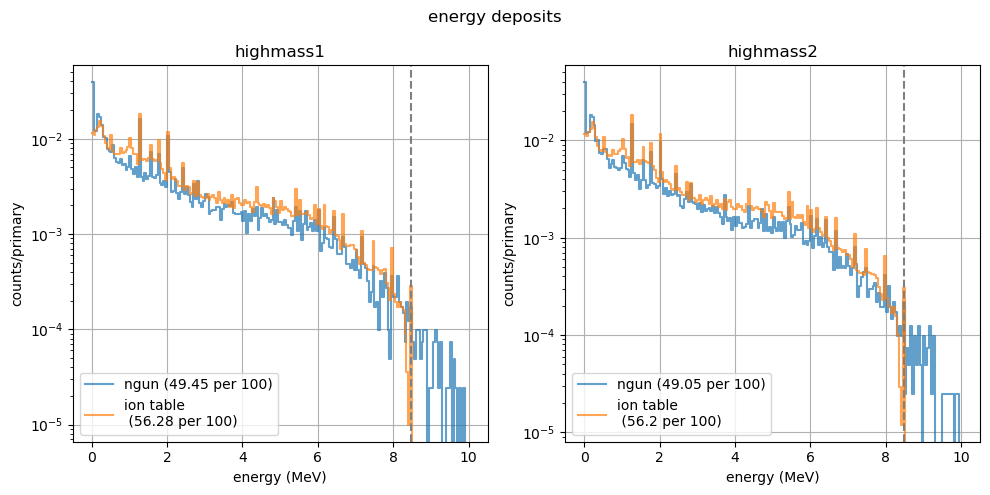

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
fig.suptitle('energy deposits')
for ax, det in zip(axs, ('highmass1', 'highmass2')):
    ax.grid()
    if logbins:
        ax.loglog()
    else:
        ax.semilogy()

    ngun_rate = ngun_cts[det].sum()/numcaps
    iontable_rate = iontable_cts[det].sum()/Niontable

    ax.set_title(det)
    ax.set_xlabel('energy (MeV)')
    ax.set_ylabel('counts/primary')

    ax.step(Ebins, ngun_cts[det]/numcaps, where = 'post', label = f'ngun ({ngun_rate*100:.4g} per 100)', alpha = 0.7)

    ax.step(Ebins, iontable_cts[det]/Niontable, where = 'post', label = f'ion table\n ({iontable_rate*100:.4g} per 100)', alpha = 0.7)

    ax.axvline(8.4736, linestyle = '--', color = 'gray')
    #ax.axvline(4.84034, linestyle = '--', color = 'gray')
    #ax.axvline(4.9344, linestyle = '--', color = 'gray')

    ax.legend()
    #ax.axis((4, 6, 1e-3, 1e-2))

fig.tight_layout()

In [10]:
for det in detectors:
    print(f'{det}: {ngun_cts[det].sum()} ngun, {iontable_cts[det].sum()} iontable')

lowmass: 12877.0 ngun, 999998.0 iontable
highmass1: 20205.0 ngun, 562757.0 iontable
highmass2: 20041.0 ngun, 561998.0 iontable


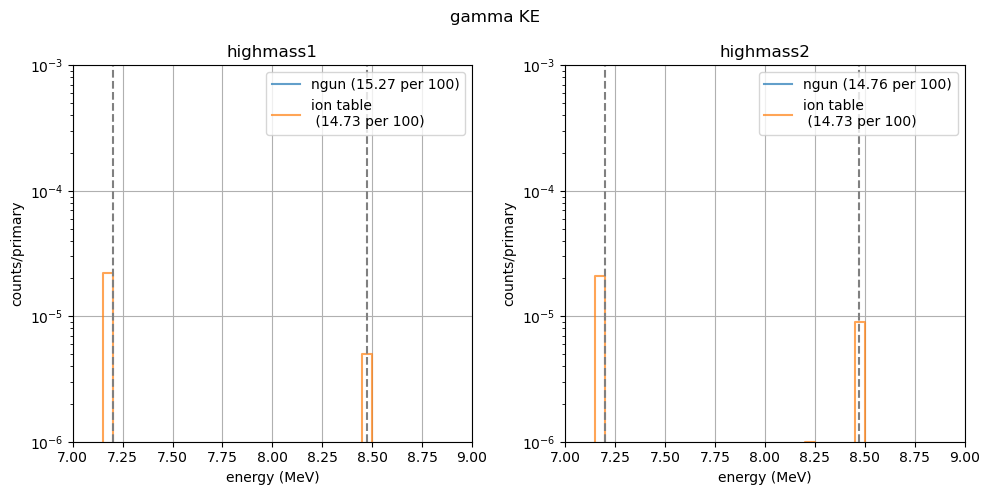

In [11]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
fig.suptitle('gamma KE')
for ax, det in zip(axs, ('highmass1', 'highmass2')):
    ax.grid()
    if logbins:
        ax.loglog()
    else:
        ax.semilogy()

    ngun_rate = ngungam_cts[det].sum()/numcaps
    iontable_rate = iontablegam_cts[det].sum()/Niontable

    ax.set_title(det)
    ax.set_xlabel('energy (MeV)')
    ax.set_ylabel('counts/primary')

    ax.step(Ebins, ngungam_cts[det]/numcaps, where = 'post', label = f'ngun ({ngun_rate*100:.4g} per 100)', alpha = 0.7)

    ax.step(Ebins, iontablegam_cts[det]/Niontable, where = 'post', label = f'ion table\n ({iontable_rate*100:.4g} per 100)', alpha = 0.7)

    ax.axvline(8.4736, linestyle = '--', color = 'gray')
    ax.axvline(4.84034, linestyle = '--', color = 'gray')
    ax.axvline(4.9344, linestyle = '--', color = 'gray')
    ax.axvline(8.4736 - 1.2734, linestyle = '--', color = 'gray')
    

    ax.legend()
    ax.axis((7, 9, 1e-6, 1e-3))
    #ax.axis((4, 6, 1e-6, 1e-3))

fig.tight_layout()

In [12]:
8.4736 - 1.2734

7.200199999999999

(2.0, 9.0)

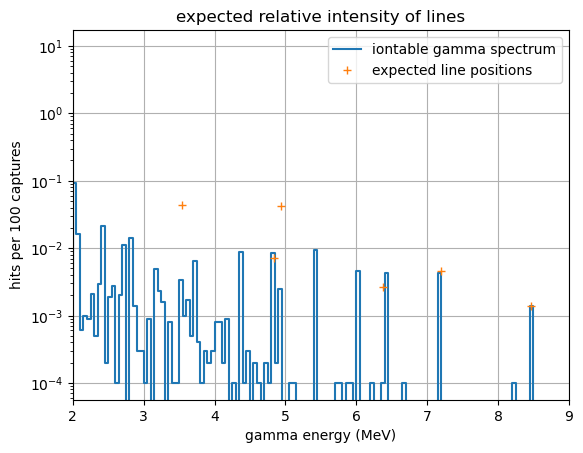

In [13]:

lines, heights = np.array([
    [4.9344, 62.6],
    [4.8403, 10.7],
    [8.4736, 2.1],
    [8.4736 - 1.2734, 6.8],
    [6.3806, 4],
    [8.4736 - 4.9344, 62.6 + 3.9],
    [1.2734, 6.8 + 3.9]
]).T


spec = (iontablegam_cts['highmass1']+iontablegam_cts['highmass2'])/Niontable

plt.figure()
plt.grid()
plt.xlabel('gamma energy (MeV)')
plt.ylabel('hits per 100 captures')
plt.title('expected relative intensity of lines')
plt.semilogy()
plt.step(Ebins, spec*100, where = 'post', label = 'iontable gamma spectrum')
plt.plot(lines, 100*heights*spec[-32]/2.1, '+', label = 'expected line positions')
plt.legend()
plt.xlim(2, 9)

In [14]:
spec[-32]

1.4e-05

In [25]:
# straight-to-ground events
evtpercapture = spec[np.where(spec>0)[0][-1]]
capture_freq = 0.056 # Hz
evt_frequency = evtpercapture*capture_freq # Hz
print(evt_frequency, 'Hz')
print(f'{evt_frequency*3600*24:.4g} per day')
print(f'{evt_frequency*3600*24*365:.4g} per year')

7.84e-07 Hz
0.06774 per day
24.72 per year


In [24]:
f'{evtpercapture*100:.5f}'

'0.00140'